# Fraud Detection Model Development
## Real-World Anomaly Detection Assignment

## Setup and Data Loading

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import IsolationForest
from sklearn.svm import OneClassSVM
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
from sklearn.metrics import precision_score, recall_score, f1_score, precision_recall_curve
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import joblib

# Set random seeds
np.random.seed(42)
tf.random.set_seed(42)

print("Libraries imported successfully")

Libraries imported successfully


C:\Users\91630\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\export\tf2onnx_lib.py:8: FutureWarning: In the future `np.object` will be defined as the corresponding NumPy scalar.
  if not hasattr(np, "object"):


In [2]:
# Load dataset
df = pd.read_csv('transactions.csv')
print(f"Dataset shape: {df.shape}")
print(f"\nFraud rate: {df['is_fraud'].mean():.2%}")
df.head()

Dataset shape: (100000, 15)

Fraud rate: 2.00%


,transaction_id,customer_id,card_number,timestamp,amount,merchant_id,merchant_category,merchant_lat,merchant_long,is_fraud,fraud_type,hour,day_of_week,month,distance_from_home
0,TXN_00000000,CUST_00861,CARD_18969,2025-08-20T00:23:18Z,3117.77,MERCHANT_255,electronics,22.7890,88.6956,1,account_takeover,0,2,8,36.03
1,TXN_00000001,CUST_03773,CARD_96975,2025-09-13T21:39:57Z,840.86,MERCHANT_212,electronics,13.0835,77.4841,0,none,21,5,9,5.07
2,TXN_00000002,CUST_03093,CARD_39004,2025-09-05T12:25:30Z,4070.50,MERCHANT_577,luxury_goods,18.6067,72.4481,1,merchant_collusion,12,4,9,15.60
3,TXN_00000003,CUST_00467,CARD_83329,2025-06-20T12:58:11Z,1176.75,MERCHANT_472,grocery,28.3219,76.7205,0,none,12,4,6,8.62
4,TXN_00000004,CUST_04427,CARD_75134,2025-07-28T19:38:56Z,306.80,MERCHANT_486,gas,28.3160,76.6884,0,none,19,0,7,15.82


## Exploratory Data Analysis

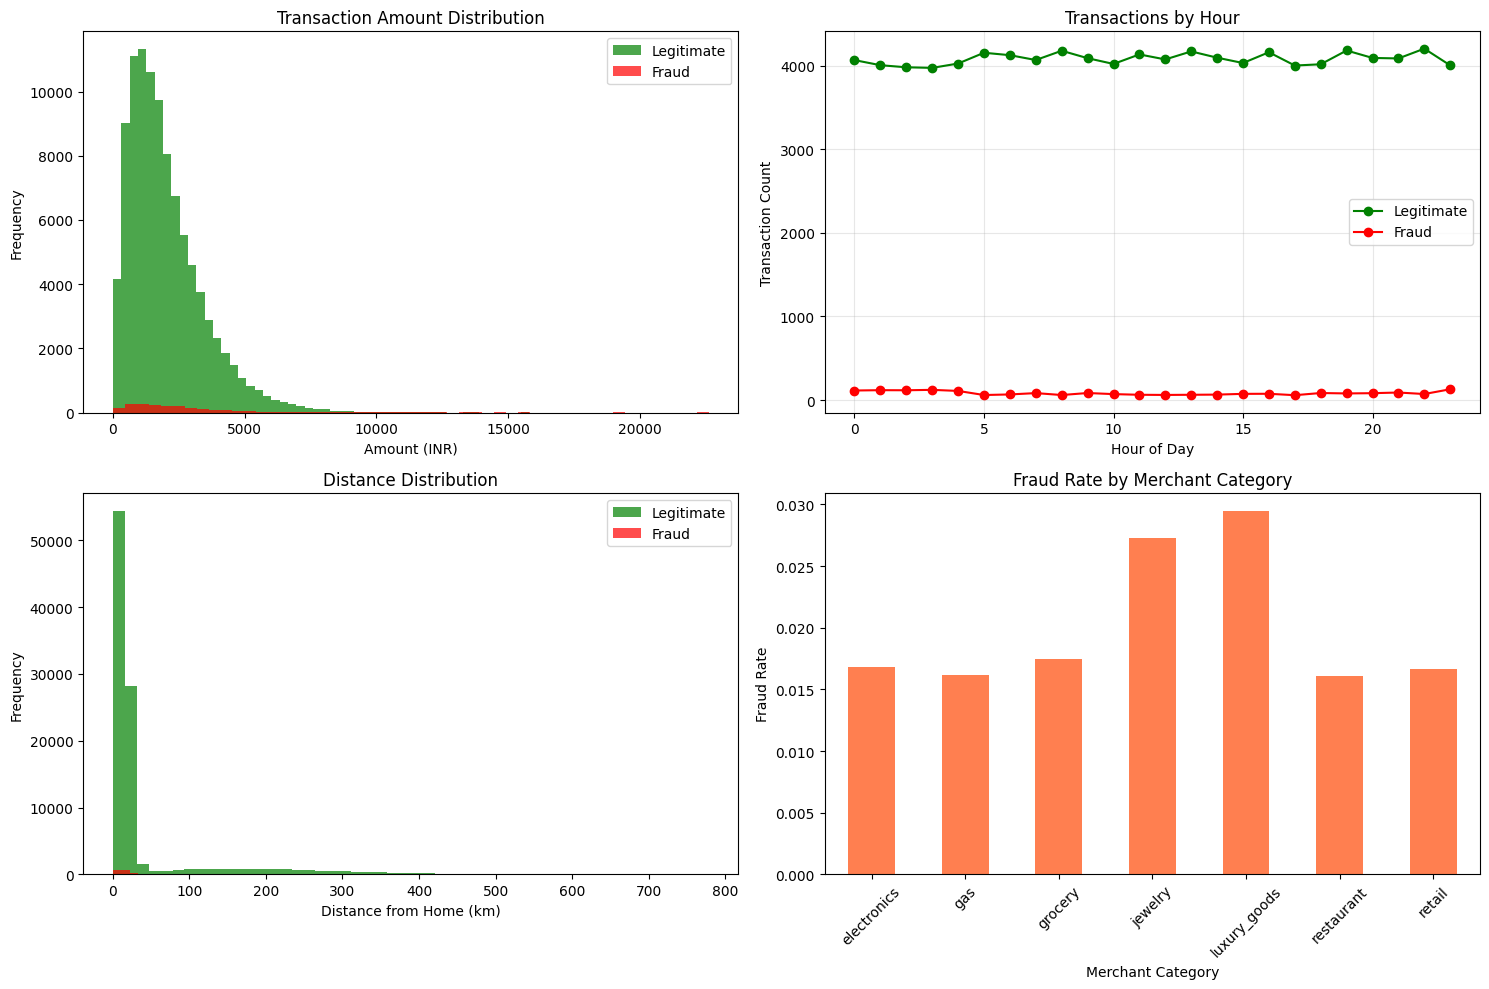


Fraud by Category:
                   sum  count  fraud_rate
merchant_category                        
luxury_goods       419  14231    0.029443
jewelry            394  14436    0.027293
grocery            249  14237    0.017490
electronics        240  14265    0.016824
retail             237  14248    0.016634
gas                231  14318    0.016134
restaurant         230  14265    0.016123


In [3]:
# Fraud distribution
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Amount distribution
axes[0, 0].hist(df[df['is_fraud']==0]['amount'], bins=50, alpha=0.7, label='Legitimate', color='green')
axes[0, 0].hist(df[df['is_fraud']==1]['amount'], bins=50, alpha=0.7, label='Fraud', color='red')
axes[0, 0].set_xlabel('Amount (INR)')
axes[0, 0].set_ylabel('Frequency')
axes[0, 0].set_title('Transaction Amount Distribution')
axes[0, 0].legend()

# Hour distribution
hour_fraud = df[df['is_fraud']==1]['hour'].value_counts().sort_index()
hour_legit = df[df['is_fraud']==0]['hour'].value_counts().sort_index()
axes[0, 1].plot(hour_legit.index, hour_legit.values, label='Legitimate', color='green', marker='o')
axes[0, 1].plot(hour_fraud.index, hour_fraud.values, label='Fraud', color='red', marker='o')
axes[0, 1].set_xlabel('Hour of Day')
axes[0, 1].set_ylabel('Transaction Count')
axes[0, 1].set_title('Transactions by Hour')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# Distance from home
axes[1, 0].hist(df[df['is_fraud']==0]['distance_from_home'], bins=50, alpha=0.7, label='Legitimate', color='green')
axes[1, 0].hist(df[df['is_fraud']==1]['distance_from_home'], bins=50, alpha=0.7, label='Fraud', color='red')
axes[1, 0].set_xlabel('Distance from Home (km)')
axes[1, 0].set_ylabel('Frequency')
axes[1, 0].set_title('Distance Distribution')
axes[1, 0].legend()

# Merchant category
category_fraud = df.groupby('merchant_category')['is_fraud'].agg(['sum', 'count'])
category_fraud['fraud_rate'] = category_fraud['sum'] / category_fraud['count']
category_fraud['fraud_rate'].plot(kind='bar', ax=axes[1, 1], color='coral')
axes[1, 1].set_xlabel('Merchant Category')
axes[1, 1].set_ylabel('Fraud Rate')
axes[1, 1].set_title('Fraud Rate by Merchant Category')
axes[1, 1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

print("\nFraud by Category:")
print(category_fraud.sort_values('fraud_rate', ascending=False))

## Feature Engineering

### Decision Log:
**Features to create:**
1. **amount_log**: Log transformation to handle skewed distribution
2. **is_high_risk_category**: Binary flag for jewelry/luxury goods
3. **is_late_night**: Binary flag for transactions 11PM-5AM
4. **is_weekend**: Weekend transactions show different patterns
5. **amount_zscore**: Standardized amount for anomaly detection
6. **distance_risk**: High distances are red flags

**Why these features:**
- Log transforms handle exponential distributions common in financial data
- Categorical encoding preserves merchant category information
- Time-based features capture temporal fraud patterns
- Distance features detect unusual geographic activity

In [4]:
def engineer_features(data):
    df_features = data.copy()
    
    # 1. Amount features
    df_features['amount_log'] = np.log1p(df_features['amount'])
    df_features['amount_squared'] = df_features['amount'] ** 2
    
    # 2. Categorical features
    df_features['is_high_risk_category'] = df_features['merchant_category'].isin(
        ['jewelry', 'luxury_goods']
    ).astype(int)
    
    # Encode merchant category
    le = LabelEncoder()
    df_features['merchant_category_encoded'] = le.fit_transform(df_features['merchant_category'])
    
    # 3. Temporal features
    df_features['is_late_night'] = ((df_features['hour'] >= 23) | (df_features['hour'] <= 4)).astype(int)
    df_features['is_weekend'] = (df_features['day_of_week'] >= 5).astype(int)
    df_features['is_business_hours'] = ((df_features['hour'] >= 9) & (df_features['hour'] <= 17)).astype(int)
    
    # 4. Distance features
    df_features['distance_risk'] = (df_features['distance_from_home'] > 50).astype(int)
    df_features['distance_log'] = np.log1p(df_features['distance_from_home'])
    
    # 5. Interaction features
    df_features['amount_distance_interaction'] = df_features['amount'] * df_features['distance_from_home']
    df_features['high_amount_late_night'] = (
        (df_features['amount'] > df_features['amount'].quantile(0.9)) & 
        (df_features['is_late_night'] == 1)
    ).astype(int)
    
    return df_features

df_engineered = engineer_features(df)
print("Feature engineering completed")
print(f"Original features: {df.shape[1]}")
print(f"Engineered features: {df_engineered.shape[1]}")
print(f"\nNew features created:")
new_features = set(df_engineered.columns) - set(df.columns)
print(list(new_features))

Feature engineering completed
Original features: 15
Engineered features: 26

New features created:
['is_late_night', 'is_high_risk_category', 'distance_log', 'high_amount_late_night', 'is_weekend', 'amount_squared', 'amount_log', 'distance_risk', 'is_business_hours', 'amount_distance_interaction', 'merchant_category_encoded']


## Data Preparation

In [5]:
feature_columns = [
    'amount', 'amount_log', 'amount_squared',
    'merchant_category_encoded', 'is_high_risk_category',
    'merchant_lat', 'merchant_long',
    'hour', 'day_of_week', 'month',
    'is_late_night', 'is_weekend', 'is_business_hours',
    'distance_from_home', 'distance_log', 'distance_risk',
    'amount_distance_interaction', 'high_amount_late_night'
]

X = df_engineered[feature_columns]
y = df_engineered['is_fraud']

# Train-test split (80-20)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Training set: {X_train.shape[0]} samples")
print(f"Test set: {X_test.shape[0]} samples")
print(f"Training fraud rate: {y_train.mean():.2%}")
print(f"Test fraud rate: {y_test.mean():.2%}")

Training set: 80000 samples
Test set: 20000 samples
Training fraud rate: 2.00%
Test fraud rate: 2.00%


In [6]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

X_train_normal = X_train_scaled[y_train == 0]
print(f"\nNormal transactions for training: {X_train_normal.shape[0]}")

# Save scaler
joblib.dump(scaler, 'models/scaler.pkl')
print("Scaler saved successfully")


Normal transactions for training: 78400
Scaler saved successfully


## 5. Model Development

### Approach 1: Isolation Forest

In [7]:
print("Training Isolation Forest...")
iso_forest = IsolationForest(
    contamination=0.02, 
    random_state=42,
    n_estimators=100,
    max_samples='auto',
    n_jobs=-1
)

iso_forest.fit(X_train_normal)

# Predictions (returns -1 for outliers, 1 for inliers)
iso_pred_train = iso_forest.predict(X_train_scaled)
iso_pred_test = iso_forest.predict(X_test_scaled)

# Convert to binary (1=fraud, 0=normal)
iso_pred_train_binary = (iso_pred_train == -1).astype(int)
iso_pred_test_binary = (iso_pred_test == -1).astype(int)

# Anomaly scores (higher = more anomalous)
iso_scores_train = -iso_forest.score_samples(X_train_scaled)
iso_scores_test = -iso_forest.score_samples(X_test_scaled)

print("Isolation Forest trained successfully")

Training Isolation Forest...
Isolation Forest trained successfully


### Approach 2: One-Class SVM

In [8]:
print("Training One-Class SVM...")
sample_size = min(20000, len(X_train_normal))
sample_indices = np.random.choice(len(X_train_normal), sample_size, replace=False)
X_train_svm = X_train_normal[sample_indices]

oc_svm = OneClassSVM(
    kernel='rbf',
    gamma='scale',
    nu=0.02,  # Expected fraud rate
)

oc_svm.fit(X_train_svm)

# Predictions
svm_pred_train = oc_svm.predict(X_train_scaled)
svm_pred_test = oc_svm.predict(X_test_scaled)

# Convert to binary
svm_pred_train_binary = (svm_pred_train == -1).astype(int)
svm_pred_test_binary = (svm_pred_test == -1).astype(int)

# Decision scores
svm_scores_train = -oc_svm.decision_function(X_train_scaled)
svm_scores_test = -oc_svm.decision_function(X_test_scaled)

print("One-Class SVM trained successfully")

Training One-Class SVM...
One-Class SVM trained successfully


### Approach 3: Autoencoder

In [9]:
# Autoencoder
print("Building Autoencoder...")

input_dim = X_train_scaled.shape[1]

# Encoder
encoder_input = layers.Input(shape=(input_dim,))
x = layers.Dense(64, activation='relu')(encoder_input)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.2)(x)
x = layers.Dense(32, activation='relu')(x)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.2)(x)
x = layers.Dense(16, activation='relu')(x)
encoded = layers.Dense(8, activation='relu', name='bottleneck')(x)

# Decoder
x = layers.Dense(16, activation='relu')(encoded)
x = layers.BatchNormalization()(x)
x = layers.Dense(32, activation='relu')(x)
x = layers.BatchNormalization()(x)
x = layers.Dense(64, activation='relu')(x)
decoded = layers.Dense(input_dim, activation='linear')(x)

autoencoder = keras.Model(encoder_input, decoded)
autoencoder.compile(optimizer='adam', loss='mse', metrics=['mae'])

print(autoencoder.summary())

Building Autoencoder...


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 18)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 64)                  │           1,216 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 64)                  │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 32)                  │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 16)                  │             528 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bottleneck (Dense)                   │ (None, 8)                   │             136 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 16)                  │             144 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 16)                  │              64 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 32)                  │             544 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 32)                  │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 64)                  │           2,112 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 18)                  │           1,170 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 8,506 (33.23 KB)

 Trainable params: 8,218 (32.10 KB)

 Non-trainable params: 288 (1.12 KB)

None


Epoch 1/50
276/276 ━━━━━━━━━━━━━━━━━━━━ 10s 13ms/step - loss: 0.6493 - mae: 0.5851 - val_loss: 0.4200 - val_mae: 0.4678
Epoch 2/50
276/276 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 0.3910 - mae: 0.4313 - val_loss: 0.2962 - val_mae: 0.3641
Epoch 3/50
276/276 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 0.3280 - mae: 0.3861 - val_loss: 0.2442 - val_mae: 0.3212
Epoch 4/50
276/276 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.2921 - mae: 0.3586 - val_loss: 0.2102 - val_mae: 0.2892
Epoch 5/50
276/276 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.2660 - mae: 0.3401 - val_loss: 0.1822 - val_mae: 0.2724
Epoch 6/50
276/276 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.2381 - mae: 0.3238 - val_loss: 0.1549 - val_mae: 0.2530
Epoch 7/50
276/276 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.2148 - mae: 0.3069 - val_loss: 0.1316 - val_mae: 0.2348
Epoch 8/50
276/276 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.1915 - mae: 0.2894 - val_loss: 0.1002 - val_mae: 0.2032
Epoch 9/50
276/276 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step -

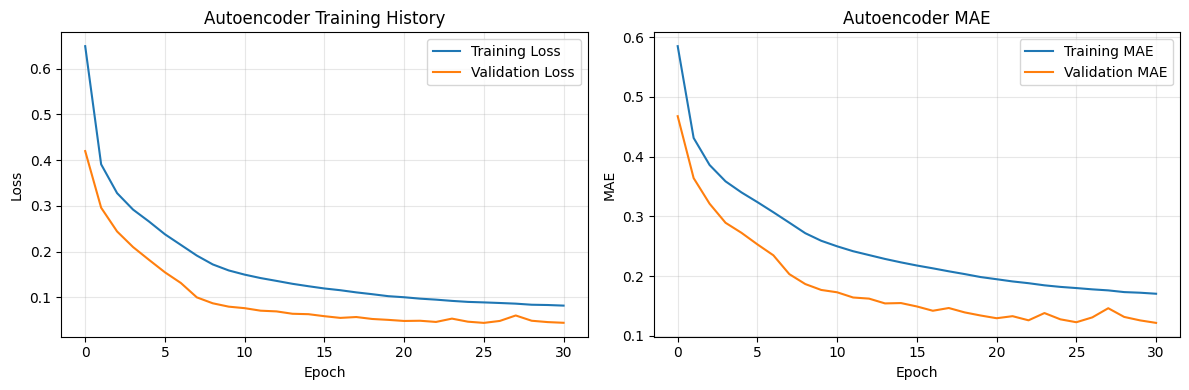

In [10]:
# Train autoencoder
early_stopping = keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

history = autoencoder.fit(
    X_train_normal, X_train_normal,
    epochs=50,
    batch_size=256,
    validation_split=0.1,
    callbacks=[early_stopping],
    verbose=1
)

# Plot training history
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Autoencoder Training History')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
plt.plot(history.history['mae'], label='Training MAE')
plt.plot(history.history['val_mae'], label='Validation MAE')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.title('Autoencoder MAE')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 6. Model Evaluation & Comparison

In [11]:
# Calculate reconstruction errors
print("Calculating autoencoder predictions...")

# Get reconstructions
reconstructions_train = autoencoder.predict(X_train_scaled, verbose=0)
reconstructions_test = autoencoder.predict(X_test_scaled, verbose=0)

# Calculate reconstruction error (Mean Absolute Error per sample)
ae_scores_train = np.mean(np.abs(X_train_scaled - reconstructions_train), axis=1)
ae_scores_test = np.mean(np.abs(X_test_scaled - reconstructions_test), axis=1)

# Determine threshold (98th percentile of normal training data reconstruction error)
# We use only normal transactions to set the threshold
normal_train_indices = (y_train == 0)
threshold = np.percentile(ae_scores_train[normal_train_indices], 98)

print(f"Autoencoder reconstruction error threshold: {threshold:.4f}")
print(f"  - Normal transactions mean error: {ae_scores_train[normal_train_indices].mean():.4f}")
print(f"  - Normal transactions 98th percentile: {threshold:.4f}")

# Predictions based on threshold
# If reconstruction error > threshold, it's an anomaly (fraud)
ae_pred_train_binary = (ae_scores_train > threshold).astype(int)
ae_pred_test_binary = (ae_scores_test > threshold).astype(int)

print(f"\nAutoencoder predictions:")
print(f"  - Training frauds detected: {ae_pred_train_binary.sum()} / {y_train.sum()}")
print(f"  - Test frauds detected: {ae_pred_test_binary.sum()} / {y_test.sum()}")
print("Autoencoder predictions calculated successfully!")

Calculating autoencoder predictions...
Autoencoder reconstruction error threshold: 0.2716
  - Normal transactions mean error: 0.1230
  - Normal transactions 98th percentile: 0.2716

Autoencoder predictions:
  - Training frauds detected: 1714 / 1600
  - Test frauds detected: 464 / 400
Autoencoder predictions calculated successfully!


In [12]:
def evaluate_model(y_true, y_pred, scores, model_name):
    print(f"\n{'='*60}")
    print(f"{model_name} - Test Set Performance")
    print(f"{'='*60}")
    
    # Classification metrics
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1-Score: {f1:.4f}")
    
    # ROC-AUC
    auc = roc_auc_score(y_true, scores)
    print(f"AUC-ROC: {auc:.4f}")
    
    # Confusion Matrix
    cm = confusion_matrix(y_true, y_pred)
    tn, fp, fn, tp = cm.ravel()
    
    print(f"\nConfusion Matrix:")
    print(f"  TN: {tn:6d}  |  FP: {fp:6d}")
    print(f"  FN: {fn:6d}  |  TP: {tp:6d}")
    
    # False positive rate
    fpr = fp / (fp + tn)
    print(f"\nFalse Positive Rate: {fpr:.4f}")
    print(f"False Negative Rate: {fn / (fn + tp):.4f}")
    
    return {
        'model': model_name,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'auc': auc,
        'fpr': fpr,
        'confusion_matrix': cm
    }

# Evaluate all models
results = []
results.append(evaluate_model(y_test, iso_pred_test_binary, iso_scores_test, "Isolation Forest"))
results.append(evaluate_model(y_test, svm_pred_test_binary, svm_scores_test, "One-Class SVM"))
results.append(evaluate_model(y_test, ae_pred_test_binary, ae_scores_test, "Autoencoder"))


Isolation Forest - Test Set Performance
Precision: 0.1008
Recall: 0.1200
F1-Score: 0.1096
AUC-ROC: 0.6301

Confusion Matrix:
  TN:  19172  |  FP:    428
  FN:    352  |  TP:     48

False Positive Rate: 0.0218
False Negative Rate: 0.8800

One-Class SVM - Test Set Performance
Precision: 0.0771
Recall: 0.1050
F1-Score: 0.0889
AUC-ROC: 0.5751

Confusion Matrix:
  TN:  19097  |  FP:    503
  FN:    358  |  TP:     42

False Positive Rate: 0.0257
False Negative Rate: 0.8950

Autoencoder - Test Set Performance
Precision: 0.0733
Recall: 0.0850
F1-Score: 0.0787
AUC-ROC: 0.5734

Confusion Matrix:
  TN:  19170  |  FP:    430
  FN:    366  |  TP:     34

False Positive Rate: 0.0219
False Negative Rate: 0.9150


In [13]:
results_df = pd.DataFrame(results)
print("\n" + "="*80)
print("MODEL COMPARISON SUMMARY")
print("="*80)
print(results_df[['model', 'precision', 'recall', 'f1', 'auc', 'fpr']].to_string(index=False))
print("="*80)


MODEL COMPARISON SUMMARY
           model  precision  recall       f1      auc      fpr
Isolation Forest   0.100840   0.120 0.109589 0.630086 0.021837
   One-Class SVM   0.077064   0.105 0.088889 0.575136 0.025663
     Autoencoder   0.073276   0.085 0.078704 0.573389 0.021939


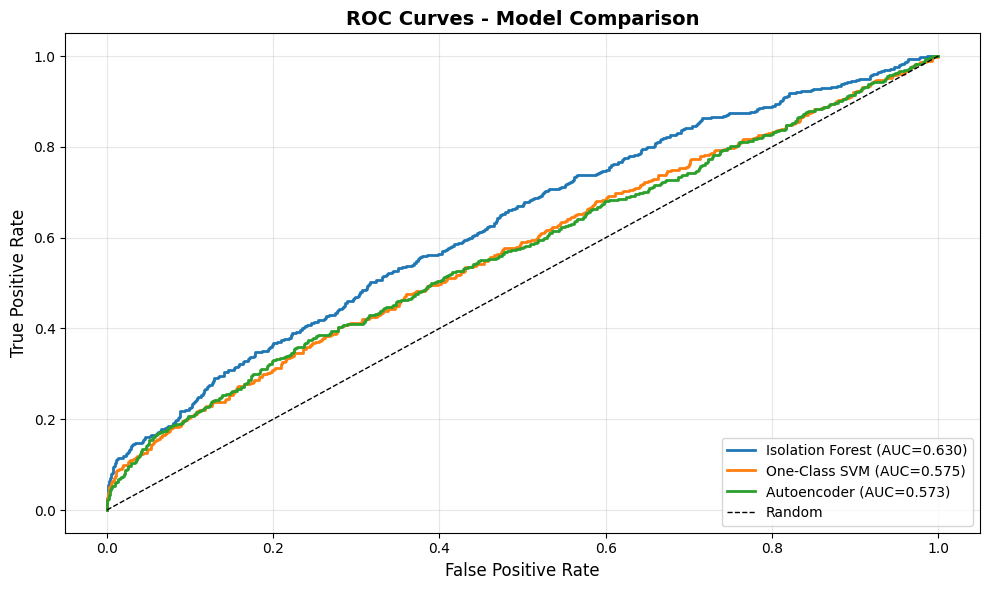

In [14]:
# Visualization: ROC Curves
plt.figure(figsize=(10, 6))

# Isolation Forest
fpr_iso, tpr_iso, _ = roc_curve(y_test, iso_scores_test)
plt.plot(fpr_iso, tpr_iso, label=f'Isolation Forest (AUC={results[0]["auc"]:.3f})', linewidth=2)

# One-Class SVM
fpr_svm, tpr_svm, _ = roc_curve(y_test, svm_scores_test)
plt.plot(fpr_svm, tpr_svm, label=f'One-Class SVM (AUC={results[1]["auc"]:.3f})', linewidth=2)

# Autoencoder
fpr_ae, tpr_ae, _ = roc_curve(y_test, ae_scores_test)
plt.plot(fpr_ae, tpr_ae, label=f'Autoencoder (AUC={results[2]["auc"]:.3f})', linewidth=2)

# Diagonal line
plt.plot([0, 1], [0, 1], 'k--', label='Random', linewidth=1)

plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('ROC Curves - Model Comparison', fontsize=14, fontweight='bold')
plt.legend(loc='lower right', fontsize=10)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

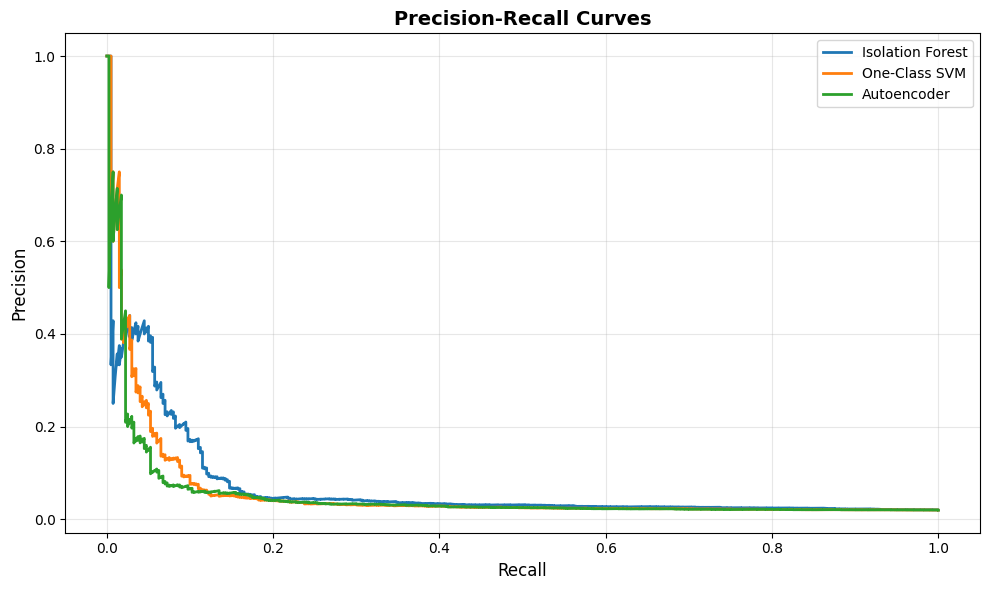

In [15]:
# Precision-Recall Curves
plt.figure(figsize=(10, 6))

# Isolation Forest
precision_iso, recall_iso, _ = precision_recall_curve(y_test, iso_scores_test)
plt.plot(recall_iso, precision_iso, label='Isolation Forest', linewidth=2)

# One-Class SVM
precision_svm, recall_svm, _ = precision_recall_curve(y_test, svm_scores_test)
plt.plot(recall_svm, precision_svm, label='One-Class SVM', linewidth=2)

# Autoencoder
precision_ae, recall_ae, _ = precision_recall_curve(y_test, ae_scores_test)
plt.plot(recall_ae, precision_ae, label='Autoencoder', linewidth=2)

plt.xlabel('Recall', fontsize=12)
plt.ylabel('Precision', fontsize=12)
plt.title('Precision-Recall Curves', fontsize=14, fontweight='bold')
plt.legend(loc='upper right', fontsize=10)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## 7. Edge Case Analysis

In [16]:
# Analyze model performance on different fraud types
test_data = df_engineered.iloc[X_test.index].copy()
test_data['iso_pred'] = iso_pred_test_binary
test_data['svm_pred'] = svm_pred_test_binary
test_data['ae_pred'] = ae_pred_test_binary

print("\nPerformance by Fraud Type:")
print("="*80)

fraud_types = test_data[test_data['is_fraud'] == 1]['fraud_type'].unique()
for fraud_type in fraud_types:
    if fraud_type == 'none':
        continue
    
    fraud_mask = (test_data['fraud_type'] == fraud_type) & (test_data['is_fraud'] == 1)
    fraud_subset = test_data[fraud_mask]
    
    print(f"\n{fraud_type.upper()}:")
    print(f"  Count: {len(fraud_subset)}")
    print(f"  Isolation Forest Recall: {fraud_subset['iso_pred'].mean():.2%}")
    print(f"  One-Class SVM Recall: {fraud_subset['svm_pred'].mean():.2%}")
    print(f"  Autoencoder Recall: {fraud_subset['ae_pred'].mean():.2%}")


Performance by Fraud Type:

MERCHANT_COLLUSION:
  Count: 171
  Isolation Forest Recall: 0.00%
  One-Class SVM Recall: 3.51%
  Autoencoder Recall: 0.58%

CARD_CLONING:
  Count: 152
  Isolation Forest Recall: 31.58%
  One-Class SVM Recall: 23.68%
  Autoencoder Recall: 21.05%

ACCOUNT_TAKEOVER:
  Count: 77
  Isolation Forest Recall: 0.00%
  One-Class SVM Recall: 0.00%
  Autoencoder Recall: 1.30%


In [17]:
# Analyze performance by amount ranges
print("\n\nPerformance by Transaction Amount:")
print("="*80)

amount_bins = [0, 1000, 5000, 10000, 50000, np.inf]
amount_labels = ['<1K', '1K-5K', '5K-10K', '10K-50K', '>50K']
test_data['amount_range'] = pd.cut(test_data['amount'], bins=amount_bins, labels=amount_labels)

for amount_range in amount_labels:
    range_mask = (test_data['amount_range'] == amount_range) & (test_data['is_fraud'] == 1)
    range_subset = test_data[range_mask]
    
    if len(range_subset) > 0:
        print(f"\n{amount_range} INR:")
        print(f"  Fraud count: {len(range_subset)}")
        print(f"  Isolation Forest Recall: {range_subset['iso_pred'].mean():.2%}")
        print(f"  One-Class SVM Recall: {range_subset['svm_pred'].mean():.2%}")
        print(f"  Autoencoder Recall: {range_subset['ae_pred'].mean():.2%}")



Performance by Transaction Amount:

<1K INR:
  Fraud count: 90
  Isolation Forest Recall: 1.11%
  One-Class SVM Recall: 0.00%
  Autoencoder Recall: 0.00%

1K-5K INR:
  Fraud count: 263
  Isolation Forest Recall: 4.94%
  One-Class SVM Recall: 4.18%
  Autoencoder Recall: 2.66%

5K-10K INR:
  Fraud count: 42
  Isolation Forest Recall: 69.05%
  One-Class SVM Recall: 61.90%
  Autoencoder Recall: 52.38%

10K-50K INR:
  Fraud count: 5
  Isolation Forest Recall: 100.00%
  One-Class SVM Recall: 100.00%
  Autoencoder Recall: 100.00%


## Model Selection & Justification

## Save Models

In [18]:
import os
os.makedirs('models', exist_ok=True)

# Save all models
joblib.dump(iso_forest, 'models/isolation_forest.pkl')
joblib.dump(oc_svm, 'models/one_class_svm.pkl')
autoencoder.save('models/autoencoder.h5')
joblib.dump(scaler, 'models/scaler.pkl')

# Save threshold
joblib.dump({'threshold': threshold}, 'models/autoencoder_threshold.pkl')

# Save feature columns
joblib.dump(feature_columns, 'models/feature_columns.pkl')

print("All models saved successfully!")
print("\nSaved files:")
for file in os.listdir('models'):
    print(f"  - models/{file}")

All models saved successfully!

Saved files:
  - models/autoencoder.h5
  - models/autoencoder_threshold.pkl
  - models/feature_columns.pkl
  - models/isolation_forest.pkl
  - models/one_class_svm.pkl
  - models/scaler.pkl
